# Описание проекта

Имеются данные по трём регионам, полученные с помощью спутника. В каждом регионе 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо разработать модель машинного обучения, которая поможет определить регион, где добыча наиболее прибыльна.

# Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
# Misc libs
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

# Scikit-learn libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Auxiliary libs
import warnings
from IPython.display import display

Настроим среду.

In [2]:
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('precision', 2)

# random_state
r_state = 123

## Ознакомление с данными

Откроем файлы и ознакомимся с данными.

In [3]:
reg = []
reg.append(pd.read_csv('/datasets/geo_data_0.csv'))
reg.append(pd.read_csv('/datasets/geo_data_1.csv'))
reg.append(pd.read_csv('/datasets/geo_data_2.csv'))

In [4]:
# The function displays the general information of the data.

def df_info(df):
    display(df.head())
    display(df.info())
    display(df.describe())

In [5]:
df_info(reg[0])

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [6]:
df_info(reg[1])

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-5.88e-03,3.18
1,62mP7,14.27,-3.48,9.99e-01,26.95
2,vyE1P,6.26,-5.95,5.00e+00,134.77
3,KcrkZ,-13.08,-11.51,5.00e+00,137.95
4,AHL4O,12.70,-8.15,5.00e+00,134.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [7]:
df_info(reg[2])

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,1.00e+05,1.00e+05,100000.00,100000.00
mean,2.02e-03,-2.08e-03,2.50,95.00
std,1.73e+00,1.73e+00,3.47,44.75
min,-8.76e+00,-7.08e+00,-11.97,0.00
25%,-1.16e+00,-1.17e+00,0.13,59.45
50%,9.42e-03,-9.48e-03,2.48,94.93
75%,1.16e+00,1.16e+00,4.86,130.60
max,7.24e+00,7.84e+00,16.74,190.03


Для всех трёх таблиц: данные распознались корректно; пропусков нет; столбец *id* является лишним, и его следует удалить; признаки *f0*, *f1*, *f2* различаются в несколько раз (это видно по средним и стандартным отклонениям), и их необходимо масштабировать.

## Предобработка данных

Проверим таблицы на наличие дубликатов.

In [8]:
for i, df in enumerate(reg):
    print('region {}:\n{}'.format(i, 
                                  str('whole row duplicated: {}\nid duplicated only:   {}\n'
                                      .format(df.duplicated().sum(),
                                              df.id.duplicated().sum()
                                             )
                                     )
                                 )
         )

region 0:
whole row duplicated: 0
id duplicated only:   10

region 1:
whole row duplicated: 0
id duplicated only:   4

region 2:
whole row duplicated: 0
id duplicated only:   4



Есть незначительное количество дубликатов по *id*, т.е одна и та же "скважина" встречается несколько раз с различными значениями признаков. Скорее всего, дубликаты возникли из-за особенностей сбора данных. Удалять их смысла не имеет как минимум потому, что их количество пренебрежимо мало, и на дальнейшие расчёты эти дубликаты не повлияют, а работать с таблицей, в которой круглое количество строк, - удобнее.

Проверим, есть ли "нулевые" строки -  неявные пропуски.

In [9]:
for i, df in enumerate(reg):
    print('region {}: {}'.format(i, 
                                 df[(df['f0'] == 0) 
                                    & (df['f1'] == 0) 
                                    & (df['f2'] == 0)
                                   ].count().max()))

region 0: 0
region 1: 0
region 2: 0


Неявных пропусков нет.

Проверим столбец *product* на наличие нулей.

In [10]:
for i, df in enumerate(reg):
    print('region {}: {}'.format(i, df[df['product'] == 0].count().max()))

region 0: 1
region 1: 8235
region 2: 1


По одному региону целевой признак содержит 8,2% нулей. Обратим на это внимание, но делать с этим пока ничего не будем: мы ничего не знаем ни о признаках, ни о способе их получения. Поэтому нельзя однозначно сказать, аномалия это или вполне корректные данные.

Удалим столбец *id* в каждой таблице.

In [11]:
for df in reg:
    df.drop('id', axis=1, inplace=True)
    display(df.columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

## Подготовка данных к обучению

Проверим, есть ли корреляция между признаками и целевым признаком.

In [12]:
for df in reg:
    display(df.corr().round(2))

,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


,f0,f1,f2,product
f0,1.00,0.18,-0.0,-0.03
f1,0.18,1.00,-0.0,-0.01
f2,-0.00,-0.00,1.0,1.00
product,-0.03,-0.01,1.0,1.00


,f0,f1,f2,product
f0,1.0,0.0,-0.00,-0.00
f1,0.0,1.0,0.00,-0.00
f2,-0.0,0.0,1.00,0.45
product,-0.0,-0.0,0.45,1.00


Между признаками значимой корреляции нет. Заметная корреляция есть только между признаками *f0* и *f1* в датасете *0*, но, скорее всего, она не окажет существенного влияния на обучение.

А вот между целевым признаком и одним из признаков (*f2*) связь есть во всех трёх датасетах. Причём если в датасетах *0* и *2* эта связь - незначительная, то в датасете *1* наблюдается очень сильная положительная корреляция, стремящаяся к единице. Это пойдёт модели только на пользу.

Отмасштабируем признаки *f0*, *f1*, *f2* с помощью функции StandardScaler.

In [13]:
feat_list = ['f0', 'f1', 'f2']
reg_name_list = ['region_0', 'region_1', 'region_2']

In [14]:
scaler = StandardScaler()

for i in range(len(reg)):
    reg[i][feat_list] = scaler.fit_transform(reg[i][feat_list])
    display(reg[i].describe())

,f0,f1,f2,product
count,1.00e+05,1.00e+05,1.00e+05,100000.00
mean,2.29e-17,-5.04e-17,9.61e-17,92.50
std,1.00e+00,1.00e+00,1.00e+00,44.29
min,-2.19e+00,-2.18e+00,-4.49e+00,0.00
25%,-6.57e-01,-8.94e-01,-6.82e-01,56.50
50%,2.23e-03,2.17e-04,4.10e-03,91.85
75%,6.57e-01,8.93e-01,6.81e-01,128.56
max,2.14e+00,2.17e+00,4.16e+00,185.36


,f0,f1,f2,product
count,1.00e+05,1.00e+05,1.00e+05,100000.00
mean,-7.11e-18,1.85e-17,1.44e-16,68.83
std,1.00e+00,1.00e+00,1.00e+00,45.94
min,-3.65e+00,-4.21e+00,-1.47e+00,0.00
25%,-8.30e-01,-6.78e-01,-8.77e-01,26.95
50%,1.31e-03,-3.24e-03,-2.84e-01,57.09
75%,8.34e-01,6.77e-01,8.84e-01,107.81
max,3.15e+00,4.60e+00,1.48e+00,137.95


,f0,f1,f2,product
count,1.00e+05,1.00e+05,1.00e+05,100000.00
mean,2.24e-17,-1.44e-17,-1.39e-16,95.00
std,1.00e+00,1.00e+00,1.00e+00,44.75
min,-5.06e+00,-4.09e+00,-4.16e+00,0.00
25%,-6.72e-01,-6.78e-01,-6.81e-01,59.45
50%,4.27e-03,-4.28e-03,-3.14e-03,94.93
75%,6.68e-01,6.74e-01,6.80e-01,130.60
max,4.18e+00,4.53e+00,4.10e+00,190.03


Данные подготовлены к использованию в обучении моделей.

## Вывод по загрузке и подготовке данных

Данные - **в хорошем состоянии**: нет пропусков, аномалий и прочих проблем. На этапе предобработки удалены ненужные столбцы. Не этапе подготовки выполнено масштабирование признаков.

Больше никаких преобразований не потребовалось, данные подготовлены для выполнения следующего этапа.

# Обучение и проверка модели

Для обучения модели необходимо сформировать выборки. Разделим исходную выборку на обучающую и валидационную в соотношении 75:25.

Гиперпараметров, которые нужно оптимизировать, у линейной регрессии нет, поэтому можно обойтись без тестовой выборки: достаточно один раз валидировать модель после обучения и рассчитать метрики.

Кросс-валидацию делать смысла не имеет, так как обучающая выборка - очень большая, и вероятность появления заметных различий между подвыборками при кросс-валидации всё равно стремится к нулю.

Сформируем выборки.

In [15]:
feat_train = []
targ_train = []
feat_valid = []
targ_valid = []

valid_size_ratio = 0.25

for df in reg:
    feat = df[feat_list]
    targ = df['product']
    
    f_train, f_valid, t_train, t_valid = train_test_split(
        feat, targ, test_size=valid_size_ratio, random_state=r_state)
    
    feat_train.append(f_train)
    targ_train.append(t_train)
    feat_valid.append(f_valid)
    targ_valid.append(t_valid)

Создадим модель и обучим её. Выведем метрики.

Помимо квадратного корня из среднеквадратической ошибки RMSE для наглядности также рассчитаем коэффициент детерминации R2.

Рассчитаем средний предсказанный запас сырья и внесём его в эту же таблицу (для компактности).

In [16]:
pred_valid = []
pred_valid_mean = []

rmse = []
r2 = []

for i in range(len(reg)):
    model = LinearRegression()
    model.fit(feat_train[i], targ_train[i])                    #fit
    pred_valid.append(pd.Series(model.predict(feat_valid[i]))) #predict
    
    pred_valid[i] =pd.Series(pred_valid[i])
    targ_valid.append(targ_valid[i].reset_index(drop=True, inplace=True))
    
    rmse.append(np.sqrt(mean_squared_error(targ_valid[i], pred_valid[i]))) #rmse
    r2.append(r2_score(targ_valid[i], pred_valid[i]))                      #r2
    pred_valid_mean.append(np.mean(pred_valid[i]))                         #mean

pd.DataFrame(data=[rmse, r2, pred_valid_mean],
             index=['RMSE', 'R2', 'predicted mean reserve'],
             columns=reg_name_list)

,region_0,region_1,region_2
RMSE,37.65,0.90,40.13
R2,0.28,1.00,0.19
predicted mean reserve,92.55,69.28,95.10


По регионам *0* и *2* качество предсказания - очень низкое, а по региону *1* - очень высокое.

Предсказанные запасы сырья (среднее) в регионе *1* примерно на четверть меньше, чем в двух других регионах. Однако, в связи с большим разбросом значений по регионам *0* и *2* реальные запасы там могут оказаться даже меньше, чем в регионе *1*.

## Вывод по обучению и проверке модели

Результаты получились очень **контрастными**. По регионам *0* и *2* модель предсказывает плохо: коэффициент детерминации равен соответственно 0.28 и 0.19. По региону *1* - наоборот: R2 = 1.00, то есть модель предсказывает целевой признак идеально. Так происходит из-за единичной корреляции между одним из признаков и целевым признаком.

Корень из среднеквадратической ошибки **RMSE**, непосредственно отражающий абсолютный разброс значений (выраженный в той же размерности, что и сами значения), также **сильно различается**. По регионам *0* и *2* RMSE равен соответственно 37.65 и 40.13, что лишь в 2-3 раза меньше средних (т.е. сопоставим со средними), а по региону *1* RMSE=0.90, что меньше среднего на два порядка (т.е. много меньше).

Предсказания по региону *1*, скорее всего, будут очень точными. А вот по остальным регионам выдаваемые результаты можно назвать предсказаниями лишь с большой натяжкой: это, скорее, грубая оценка.

Средние запасы сырья в регионах *0* и *2* хотя и выше, чем в *1* (соответственно 92.55; 95.10 и 69.28), но разброс таков, что даже в рамках предсказания модели реальный объём в регионах *0* и *2* может оказаться как значительно больше, так и значительно меньше среднего (в том числе даже меньше, чем в регионе *1*). А по региону *1* модель практически "гарантирует", что на показанную цифру можно рассчитывать.

# Подготовка к расчёту прибыли

Создадим ссылки на массивы с объёмами запасов, задав им более понятные и логичные имена.

In [17]:
genuine = targ_valid
predict = pred_valid
predict_mean = pred_valid_mean

Отразим некоторые условия технического задания в константах.

In [18]:
budget = 1e10                    # Бюджет на разработку скважин в одном регионе
unit_income = 4.5e5              # Доход с единицы продукта (1 единица продукта = 1000 баррелей)
wells_amount_working = 200       # Количество скважин к разработке в одном регионе
wells_amount_considering = 500   # Количество скважин к рассмотрению в одном регионе

Рассчитаем средний объём сырья одной скважины, достаточный для безубыточной разработки.

In [19]:
breakeven_volume = budget / (wells_amount_working * unit_income)
round(breakeven_volume, 2)

111.11

Сравним полученный объём со средним запасом одной скважины (по регионам).

In [20]:
vol_comparison = pd.DataFrame(data=[predict_mean, predict_mean],
                 index=['predicted mean reserve', 'p.m.r. to break-even_vol. ratio'],
                 columns=reg_name_list)
vol_comparison.iloc[1, :] = vol_comparison.iloc[1, :] / breakeven_volume
vol_comparison

,region_0,region_1,region_2
predicted mean reserve,92.55,69.28,95.10
p.m.r. to breakeven_vol. ratio,0.83,0.62,0.86


## Вывод по подготовке к расчёту прибыли

**Ни в одном регионе** предсказанные запасы в среднем **не обеспечивают безубыточность** добычи и составляют в зависимости от региона от 62 до 86% от необходимого объёма.

# Расчёт прибыли и рисков 

### Функция расчёта прибыли

In [21]:
# The function computes the profit from wells chosen according to the predictions

def profit_func(gen, pred):
    predict_considering = pred.sample(n=wells_amount_considering, replace=True, random_state=state)
    genuine_considering = gen[predict_considering.index]
    
    predict_working = predict_considering.sort_values(ascending=False).head(wells_amount_working)
    genuine_working = genuine_considering[predict_working.index]

    return genuine_working.sum() * unit_income - budget

### Формирование выборок с прибылями

Применим функцию расчёта прибыли многократно, реализуя технику Bootstrap. В результате получим распределения возможных прибылей по каждому региону.

In [22]:
state = np.random.RandomState(r_state)
bootstrap_samples = 1000

income_reg = []

for i in range(len(reg)):
    income_sample = []
    for sample in range(bootstrap_samples):       
        income_sample.append(profit_func(genuine[i], predict[i]))
    income_reg.append(income_sample)

Сформируем датафрейм с рассчитанными прибылями по каждой выборке-200 (строки) по регионам (столбцы).

In [23]:
income = np.array(income_reg)
income = pd.DataFrame(data=income.T, columns=reg_name_list)
display(income.head())
display(income.shape)

,region_0,region_1,region_2
0,4.71e+08,5.92e+08,6.81e+08
1,8.37e+08,5.30e+08,7.36e+08
2,1.05e+09,1.07e+09,6.11e+08
3,7.89e+08,3.65e+08,3.64e+08
4,2.67e+08,6.35e+08,8.16e+08


(1000, 3)

### Расчёт статистик по распределениям

Найдём среднюю прибыль, границы доверительного интервала (95%) и риск убытков по каждому региону.

In [24]:
confidence_interval_proba = 0.95

confidence_interval_lower = []
confidence_interval_upper = []
mean = []
loss_risk = []

for i in range(len(reg)):
    confidence_interval_lower.append(income[reg_name_list[i]].quantile((1-confidence_interval_proba)*0.5))
    confidence_interval_upper.append(income[reg_name_list[i]].quantile(1-(1-confidence_interval_proba)*0.5))
    mean.append(income[reg_name_list[i]].mean())
    loss_risk.append(income[income[reg_name_list[i]] < 0][reg_name_list[i]].count() / len(income))    

Сформируем таблицу с рассчитанными значениями.

In [25]:
income_stats = pd.DataFrame(data=[mean, confidence_interval_lower, confidence_interval_upper, loss_risk], 
                            index=['mean profit',
                                   'lower bound of the confidence interval',
                                   'upper bound of the confidence interval',
                                   'risk of loss'],
                            columns=reg_name_list)
income_stats

,region_0,region_1,region_2
mean profit,6.95e+08,6.74e+08,5.74e+08
lower bound of the confidence interval,1.03e+08,1.76e+08,-7.81e+07
upper bound of the confidence interval,1.35e+09,1.22e+09,1.24e+09
risk of loss,1.10e-02,3.00e-03,3.90e-02


Приведём таблицу к более удобному для восприятия виду.

In [26]:
income_stats_display = income_stats.copy()
income_stats_display.iloc[0:3, :] = income_stats_display.iloc[0:3, :] * 1e-6
income_stats_display.iloc[3, :] = income_stats_display.iloc[3, :] * 100

income_stats_display.index = income_stats_display.index.where(income_stats_display.index == 'risk of loss',
                                                              income_stats_display.index + ' (M rubles)')
income_stats_display.index = income_stats_display.index.where(income_stats_display.index != 'risk of loss',
                                                              income_stats_display.index + ' (%)')
income_stats_display

,region_0,region_1,region_2
mean profit (M rubles),695.33,673.87,574.20
lower bound of the confidence interval (M rubles),102.53,175.82,-78.06
upper bound of the confidence interval (M rubles),1354.95,1217.65,1241.46
risk of loss (%),1.10,0.30,3.90


### Визуализация

Визуализируем полученные распределения.

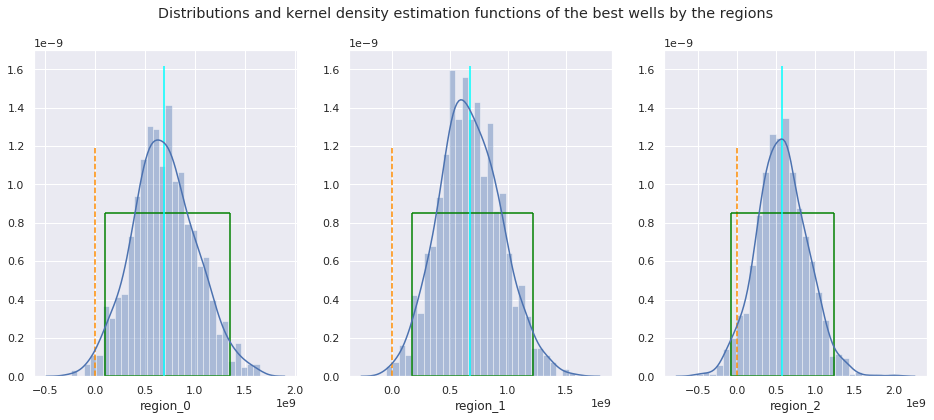

For each plot:       
The orange line displays the break-even point.       
The green rectangle displays the 95% confidence interval.       
The cyan line displays a mean value of the sample.


In [27]:
plt.figure(figsize=(16,6))
plt.suptitle('Distributions and kernel density estimation functions of the best wells by the regions')

n_bins = 30
bottom = 0.0
top = 0.0

for i in range(3):
    plt.subplot(131+i)
    sns.distplot(income[reg_name_list[i]], bins=n_bins)

    # ylim
    bottom, top_temp = plt.ylim()
    if top_temp > top:
        top = top_temp * 1.2
        plt.ylim(top=top)
    else:
        plt.ylim(top=top)
    
    # break-even point line
    plt.vlines(x=0.0, ymin=bottom, ymax=top*0.7, colors='darkorange', linestyles='dashed')
    
    # confidence interval lines
    x1 = income_stats.iloc[1, i]  # left
    x2 = income_stats.iloc[2, i]  # right
    y1 = bottom                   # bottom
    y2 = top*0.5                  # top

    plt.vlines(x=x1, ymin=y1, ymax=y2, colors='green')
    plt.vlines(x=x2, ymin=y1, ymax=y2, colors='green')
    plt.hlines(y=y1, xmin=x1, xmax=x2, colors='green')
    plt.hlines(y=y2, xmin=x1, xmax=x2, colors='green')
    
    # mean line
    plt.vlines(x=mean[i], ymin=bottom, ymax=top*0.95, colors='cyan')

# ylim (sets the highest found value on every subplot)
for i in range(3):
    plt.ylim(top=top)

plt.show()

print('For each plot:\
       \nThe orange line displays the break-even point.\
       \nThe green rectangle displays the {:.0%} confidence interval.\
       \nThe cyan line displays a mean value of the sample.'.format(confidence_interval_proba))

Распределения - нормальные, что вполне нормально.

Средние прибыли по регионам **сопоставимы** между собой и **превышают** точку безубыточности.

Доверительные интервалы также **сопоставимы** между собой. Но здесь есть **нюанс**: по региону *2* нижняя граница интервала лежит ниже точки безубыточности. По регионам *0* и *1* - выше.

Риск убытков есть во всех трёх регионах, но он - разный и различается **более чем на порядок**: от 0.3 до 3.9%.

## Вывод по расчёту прибыли и рисков

Для каждого региона:
* При помощи техники Bootstrap **сформирована выборка** с прибылями, в которой каждый объект - суммарная прибыль от 200 лучших, согласно предсказанию модели, скважин из 500 случайно выбранных скважин. В свою очередь, эти 500 скважин каждый раз случайно выбирались из 25000 объектов - вся выборка, по которым вообще сделано предсказание.
* Рассчитаны среднее, границы 95%-го доверительного интервала, риск убытков. Полученные результаты соотнесены с бюджетом на разработку в регионе, который также является точкой безубыточности.

Согласно полученным результатам, **наиболее выгодным** для разработки месторождений представляется **регион *1*** (из *0*; *1*; *2*). 

Основная причина выбора именно этого региона - **самый низкий риск убытков** (0.3%). Это в несколько раз ниже, чем по другим регионам: по регионам *0* и *2* риск убытков составляет соответственно 1.1 и 3.9%.

Вторая причина (менее значимая) - **самая высокая нижняя граница доверительного интервала**. Этот факт в данном случае не очень критичен, потому что нижние границы в абсолютном выражении различаются по регионам незначительно (разница - менее 1%).

Оценка **средней прибыли** по региону *1* - **не самая высокая**, но в данном случае это **не имеет значения**. Во-первых, различие с наибольшей средней прибылью (регион *0*) составляет всего 0.2%, что **незначительно**. Во-вторых, по региону *0* вероятность получить убыток **кратно выше**, чем по региону *1*. Высокий риск убытков ставит под сомнение целесообразность гнаться за большей прибылью вообще, не говоря уже о столь скромной прибавке.

Таким образом, **регион *1*** представляется **наиболее выгодным** для разработки.

# Общий вывод

##### Загрузка и подготовка данных

Выполнена подготовка данных: удалены ненужные столбцы (*id* скважин); выполнено масштабирование признаков (чтобы модель воспринимала признаки как равные по значимости). Выполнены также некоторые другие проверки, но они не выявили каких-либо проблем и аномалий.

##### Обучение и проверка модели

Модели по регионам *0* и *2* имеют низкое качество предсказания, в то время как по региону *1* - очень высокое, близкое к единице. Причина почти идеального качества - наличие корреляции (опять же, близкой к единице) между одним из признаков и целевым признаком. Модель по региону *1* заранее знает все ответы, что, в общем, хорошо.

В результате получены две выборки размером 25000 объектов: со значениями целевого признака и с ответами модели (предсказаниями целевого признака).

##### Подготовка к расчёту прибыли

Рассчитан средний объём сырья одной скважины, достаточный для безубыточной разработки. Затем этот объём был соотнесён с предсказанными средними запасами одной скважины по регионам: во всех трёх регионах средний запас одной скважины оказался значительно ниже необходимого для безубыточной разработки объёма.

Это означает, что разработка скважин, выбранных случайно, окажется убыточной с достаточно высокой вероятностью. Для того, чтобы обеспечить прибыльность, необходимо выполнить отбор лучших скважин.

##### Расчёт прибыли и рисков

Отбор лучших скважин выполнен с применением техники Bootstrap. Из всей выборки предсказанных значений объёма сырья (25000 объектов) случайным образом отбирается 500 объектов. Из них выбираются 200 лучших по предсказанным значениям. Затем по этим же 200 объектам, но уже по значениям реальным, а не предсказанным, рассчитывается общая прибыль по региону. Так делается много раз (1000), и формируется распределение прибылей (отдельно по каждому региону).

Расчёт показал, что каждый из трёх регионов при условии выполнения такого отбора может приносить прибыль.

По созданным выборкам (с прибылями) рассчитаны некоторые статистики: средняя прибыль, 95%-й доверительный интервал, риск убытков.

Выполнена визуализация как самих распределений, так и всех рассчитанных величин.

Описание полученных результатов:
* наименьший риск убытков - по региону *1*;
* наиболее высокая нижняя граница 95%-го доверительного интервала - по региону *1*;
* выход в прибыль с вероятностью не менее 95% - по регионам *0* и *1*;
* средняя прибыль между регионами различается незначительно.

Наибольшее значение имеет риск убытков: во-первых, он различается от региона к региону в несколько раз; во-вторых, если снижение прибыли ещё может быть приемлемо, то получение убытков - неприемлемо. Поэтому в приоритете - снижение риска убытков. Тем более, остальные показатели различаются от региона к региону не столь значительно.

##### Заключение

По совокупности всех полученных результатов наиболее предпочтительным регионом для разработки месторождений представляется регион *1*.